<a href="https://colab.research.google.com/github/anjali88/HFT-ML/blob/master/FEB__AIHFT_AZN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mxnet

     |████████████████████████████████| 68.7MB 66kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
pip install utils

In [3]:
import pandas as pd
import numpy as np
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import time
import datetime
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math

#Normalising imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.layers import LSTM
from keras.layers import Dropout, Flatten
import xgboost as xgb

#Performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

import warnings
warnings.filterwarnings("ignore")

#Setting up mxnet model Need this to create an ARIMA model and Fourier series model easily
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##DATA ACQUISITION



In [4]:
from google.colab import files
uploaded = files.upload()

Saving AZN_FEB.xlsx to AZN_FEB.xlsx


##Data Exploration (EDA)

In [ ]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

In [5]:
import io
dataset_ex_df = pd.read_excel(io.BytesIO(uploaded['AZN_FEB.xlsx']))
dataset_ex_df.head()

Dates    Open   Close    High     Low       Value  Volume
0 2018-02-14 08:00:00  4835.5  4832.5  4838.0  4832.5  78754400.0   16286
1 2018-02-14 08:01:00  4832.5  4832.5  4832.5  4832.5   1560897.5     323
2 2018-02-14 08:02:00  4834.5  4830.0  4838.0  4830.0  12914301.0    2672
3 2018-02-14 08:03:00  4832.0  4830.0  4832.5  4830.0   4237376.5     877
4 2018-02-14 08:04:00  4830.5  4829.0  4831.0  4828.5   2588807.5     536

In [ ]:
dataset_ex_df.tail()

Dates    Open   Close    High     Low         Value   Volume
5377 2018-02-28 16:26:00  2327.0  2328.0  2329.0  2327.0  2.598533e+07    11162
5378 2018-02-28 16:27:00  2327.5  2330.0  2330.0  2327.5  3.356872e+07    14410
5379 2018-02-28 16:28:00  2329.5  2326.5  2329.5  2326.0  7.079157e+07    30411
5380 2018-02-28 16:29:00  2326.5  2325.0  2326.5  2324.0  4.844795e+07    20836
5381 2018-02-28 16:35:00  2321.0  2321.0  2321.0  2321.0  4.556329e+09  1963089

In [6]:
print('There are {} number of observations in the dataset.'.format(dataset_ex_df.shape[0]))

There are 4796 number of observations in the dataset.


In [ ]:
dataset_ex_df.describe()

Open        Close  ...         Value        Volume
count  5382.000000  5382.000000  ...  5.382000e+03  5.382000e+03
mean   2295.732256  2295.725753  ...  1.860496e+07  8.088645e+03
std      19.229614    19.230778  ...  1.354947e+08  5.875959e+04
min    2255.500000  2255.000000  ...  2.327500e+03  1.000000e+00
25%    2281.500000  2281.500000  ...  2.748337e+06  1.196500e+03
50%    2291.500000  2291.500000  ...  6.588930e+06  2.874000e+03
75%    2310.000000  2310.000000  ...  1.470095e+07  6.400500e+03
max    2351.500000  2351.500000  ...  4.646882e+09  2.003398e+06

[8 rows x 6 columns]

In [ ]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 3767. Number of test days: 1615.


**1. Market Trend**

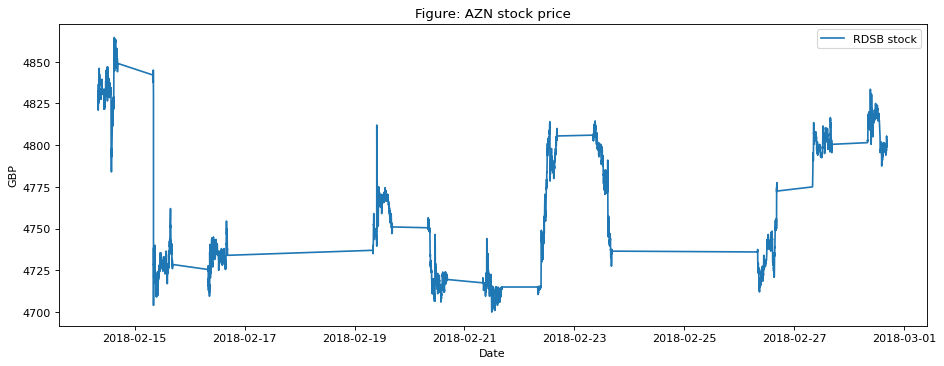

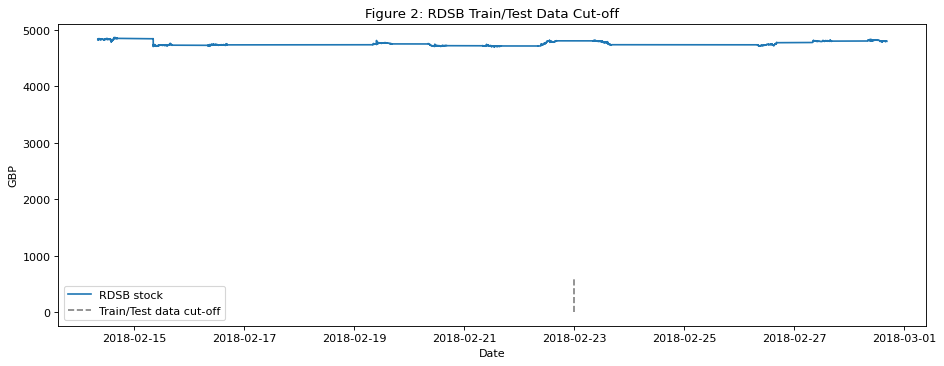

In [7]:
plt.figure(figsize=(14, 5), dpi=80)
plt.plot(dataset_ex_df['Dates'], dataset_ex_df['Close'], label='RDSB stock')
plt.xlabel('Date')
plt.ylabel('GBP')
plt.title('Figure: AZN stock price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5), dpi=80)
plt.plot(dataset_ex_df['Dates'], dataset_ex_df['Close'], label='RDSB stock')
plt.vlines(datetime.date(2018,2,23), 0, 600, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('GBP')
plt.title('Figure 2: RDSB Train/Test Data Cut-off')
plt.legend()
plt.show()

**2. Test for data stationarity - Dickey Fuller Test**
1.   Test Statistic
2.   p-Value
3.   Lags used
4.   Critical value(1%)
5.   Critical value(5%)
6.   Critical value(10%)
7.   Rolling mean
9.   Standard Deviation


In [ ]:
import statsmodels.tsa.stattools as ts

In [ ]:
def dftest(timeseries):
    """This code is from a Metis lecture on testing for stationary data with the
    Dickey Fuller test for time series analysis. It takes in a time series and outputs statistics and graphics
    If the p value is <.05, then the data passes the test and is ready for ARMA models."""
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test RDSB data stationarity:

Test Statistic            -1.784841
p-value                    0.388013
Lags Used                  6.000000
Observations Used       5375.000000
Critical Value (1%)       -3.431567
Critical Value (5%)       -2.862078
Critical Value (10%)      -2.567056
dtype: float64


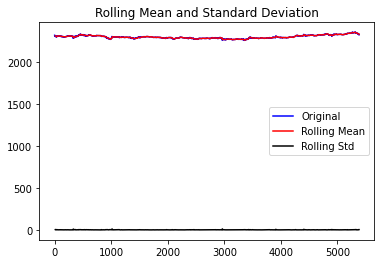

None


In [ ]:
print("Test RDSB data stationarity:\n")
print(dftest(dataset_ex_df.Close))

In [ ]:
dataset_ex_dfcopy = dataset_ex_df.copy()

> *Log Transformation*

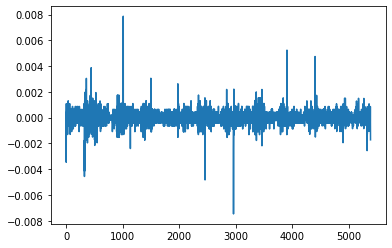

In [ ]:
dataset_ex_dfcopy['Close_log'] = np.log(dataset_ex_dfcopy['Close'])
dataset_ex_dfcopy['Close_log_diff'] = dataset_ex_dfcopy['Close_log'] - dataset_ex_dfcopy['Close_log'].shift(1)
dataset_ex_dfcopy['Close_log_diff'].dropna().plot()

In [ ]:
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

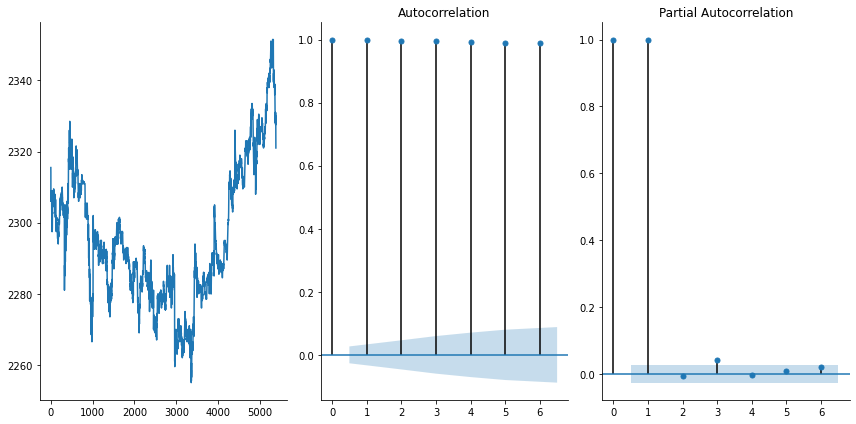

In [ ]:
plots(dataset_ex_df.Close, lags=6)

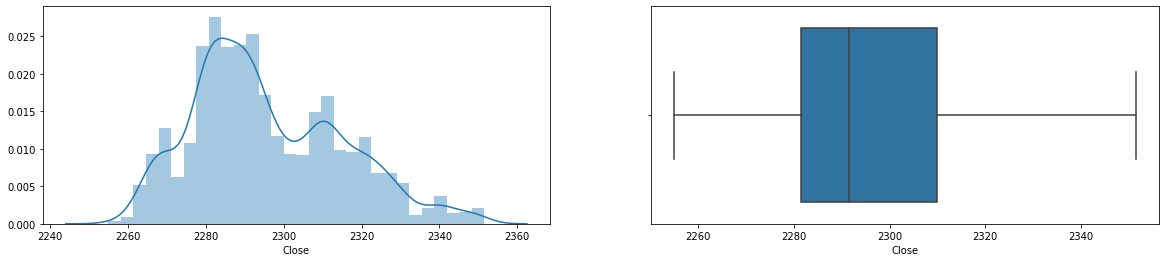

In [ ]:
f = plt.figure(figsize=(20,4))
f.add_subplot(1,2,1)
sns.distplot(dataset_ex_df['Close'])
f.add_subplot(1,2,2)
sns.boxplot(dataset_ex_df['Close'])

#Feature Generation

**1. Correlated Assets**

In [8]:
from google.colab import files
uploaded1 = files.upload()

Saving CA_FEB.xlsx to CA_FEB.xlsx


In [9]:
import io
dataset_CA = pd.read_excel(io.BytesIO(uploaded1['CA_FEB.xlsx']))
dataset_CA.head(3)

Dates    RDSB     AAL     ABF  ...     UU     VOD     WPP   WTB
0 2018-02-14 08:00:00  2315.5  1679.8  2611.0  ...  665.8  201.45  1339.5  3815
1 2018-02-14 08:01:00  2314.0  1680.8  2612.0  ...  665.8  201.55  1345.5  3818
2 2018-02-14 08:02:00  2306.0  1679.0  2611.0  ...  664.6  201.10  1343.0  3815

[3 rows x 101 columns]

In [10]:
#print shape of data with CA 
dataset_CA.shape

(5382, 101)

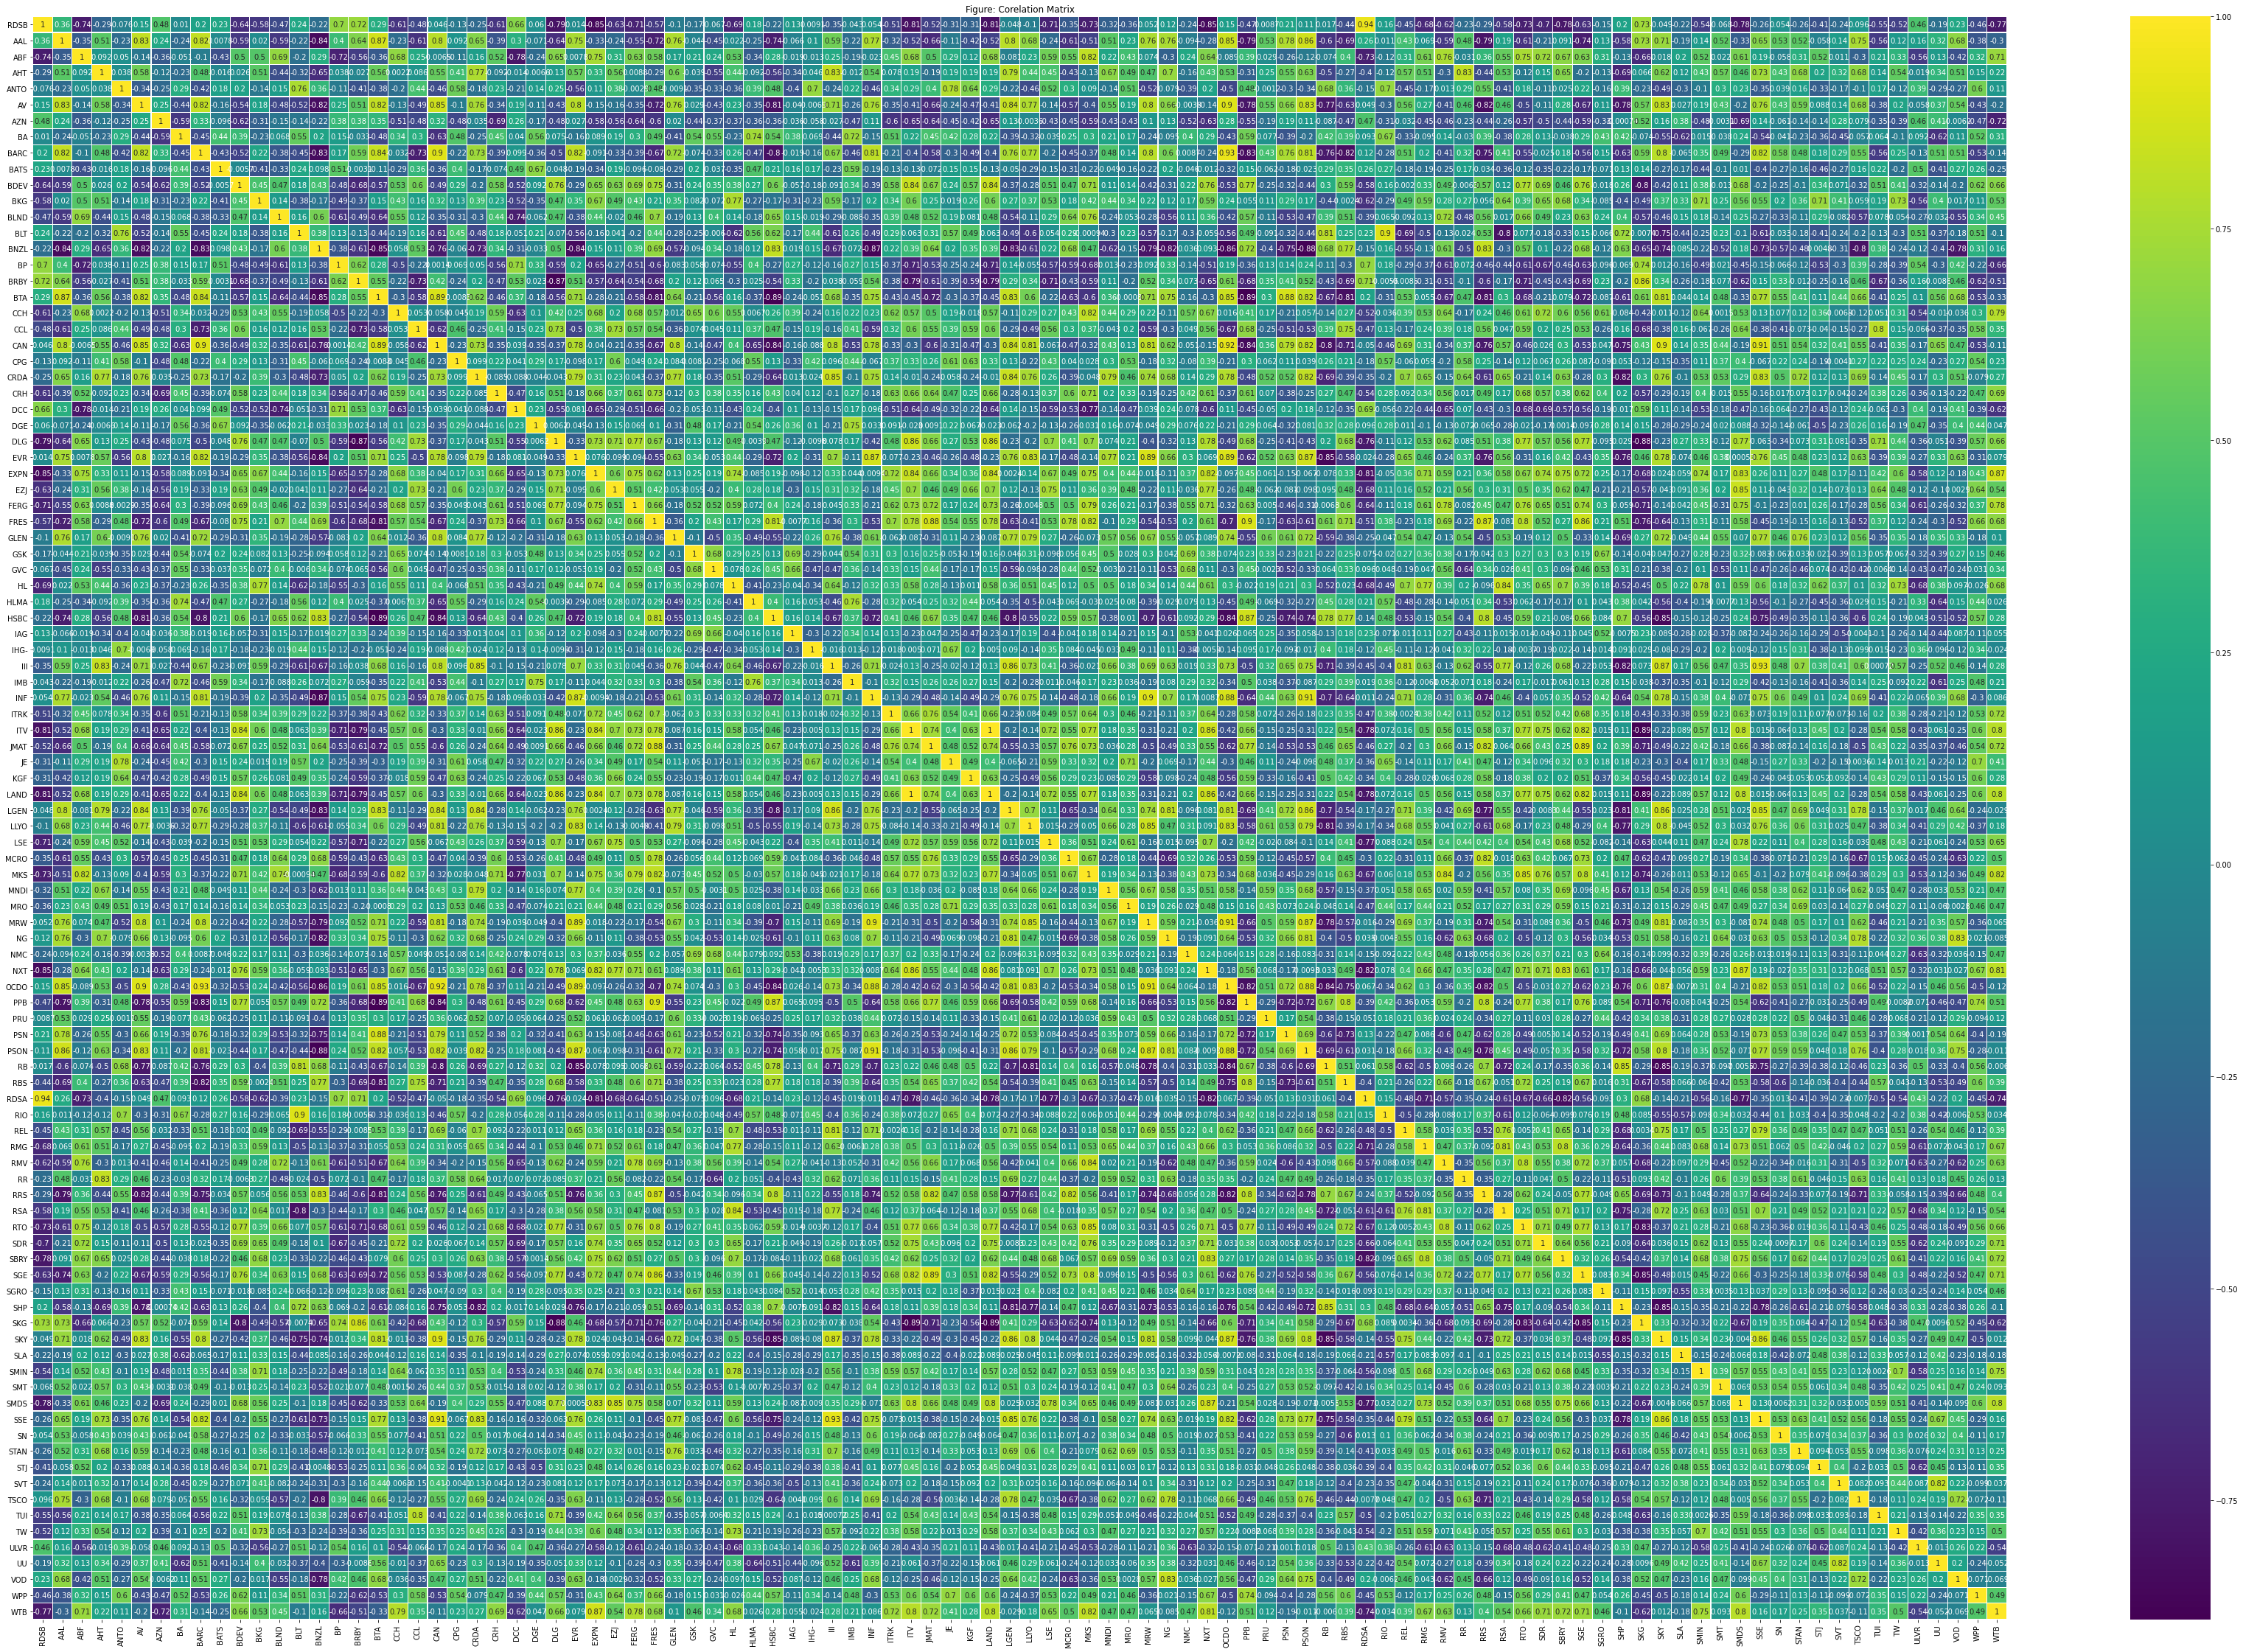

In [11]:
import seaborn as sns
cor1=dataset_CA.corr(method='pearson')
plt.figure(figsize=(60, 40))
plt.title("Figure: Corelation Matrix")
cm=plt.cm.viridis
corr = sns.heatmap(cor1,cmap=cm,linewidths=0.1,linecolor='white',annot=True)
plt.show()

In [12]:
cor_target_RDSB = abs(cor1["AZN"])
relevant_features_RDSB = cor_target_RDSB[cor_target_RDSB>0.70]
irrelevant_features_RDSB = cor_target_RDSB[cor_target_RDSB<0.70]
print("Relevant Features_RDSB:\n")
print(relevant_features_RDSB.head(10))
print("Irrelevant Features_RDSB:\n")
print(irrelevant_features_RDSB.head(10))

Relevant Features_RDSB:

AZN    1.000000
WTB    0.718521
Name: AZN, dtype: float64
Irrelevant Features_RDSB:

RDSB    0.482894
AAL     0.239989
ABF     0.363168
AHT     0.124192
ANTO    0.249050
AV      0.253404
BA      0.589079
BARC    0.334682
BATS    0.096385
BDEV    0.617626
Name: AZN, dtype: float64


In [13]:
print(relevant_features_RDSB.index.to_list())

['AZN', 'WTB']


In [14]:
print(irrelevant_features_RDSB.index.to_list())

['RDSB', 'AAL', 'ABF', 'AHT', 'ANTO', 'AV', 'BA', 'BARC', 'BATS', 'BDEV', 'BKG', 'BLND', 'BLT', 'BNZL', 'BP', 'BRBY', 'BTA', 'CCH', 'CCL', 'CAN', 'CPG', 'CRDA', 'CRH', 'DCC', 'DGE', 'DLG', 'EVR', 'EXPN', 'EZJ', 'FERG', 'FRES', 'GLEN', 'GSK', 'GVC', 'HL', 'HLMA', 'HSBC', 'IAG', 'IHG-', 'III', 'IMB', 'INF', 'ITRK', 'ITV', 'JMAT', 'JE', 'KGF', 'LAND', 'LGEN', 'LLYO', 'LSE', 'MCRO', 'MKS', 'MNDI', 'MRO', 'MRW', 'NG', 'NMC', 'NXT', 'OCDO', 'PPB', 'PRU', 'PSN', 'PSON', 'RB', 'RBS', 'RDSA', 'RIO', 'REL', 'RMG', 'RMV', 'RR', 'RRS', 'RSA', 'RTO', 'SDR', 'SBRY', 'SGE', 'SGRO', 'SHP', 'SKG', 'SKY', 'SLA', 'SMIN', 'SMT', 'SMDS', 'SSE', 'SN', 'STAN', 'STJ', 'SVT', 'TSCO', 'TUI', 'TW', 'ULVR', 'UU', 'VOD', 'WPP']


In [ ]:
dataset_CA.drop(['AAL', 'AHT', 'ANTO', 'AV', 'AZN', 'BA', 'BARC', 'BATS', 'BDEV', 'BKG', 'BLND', 'BLT', 'BNZL', 'BP', 'BTA', 'CCH', 'CCL', 'CAN', 'CPG', 'CRDA', 'CRH', 'DCC', 'DGE', 'EVR', 'EZJ', 'FRES', 'GLEN', 'GSK', 'GVC', 'HL', 'HLMA', 'HSBC', 'IAG', 'IHG-', 'III', 'IMB', 'INF', 'ITRK', 'JMAT', 'JE', 'KGF', 'LGEN', 'LLYO', 'MCRO', 'MNDI', 'MRO', 'MRW', 'NG', 'NMC', 'OCDO', 'PPB', 'PRU', 'PSN', 'PSON', 'RB', 'RBS', 'RIO', 'REL', 'RMG', 'RMV', 'RR', 'RRS', 'RSA', 'SDR', 'SGE', 'SGRO', 'SHP', 'SKY', 'SLA', 'SMIN', 'SMT', 'SSE', 'SN', 'STAN', 'STJ', 'SVT', 'TSCO', 'TUI', 'TW', 'ULVR', 'UU', 'VOD', 'WPP'], axis=1, inplace=True)
dataset_CA.head(3)

Dates    RDSB     ABF    BRBY  ...   SBRY   SKG   SMDS   WTB
0 2018-02-14 08:00:00  2315.5  2611.0  1520.5  ...  248.2  2486  473.6  3815
1 2018-02-14 08:01:00  2314.0  2612.0  1522.5  ...  247.6  2482  473.3  3818
2 2018-02-14 08:02:00  2306.0  2611.0  1524.0  ...  247.5  2488  473.5  3815

[3 rows x 18 columns]

In [15]:
dataset_CA.shape

(5382, 101)

**2. Technical Indicators**

In [16]:
def get_technical_indicators(dataset): #function to generate feature technical indicators
    
    
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1
    
    
    
    return dataset

In [17]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)
dataset_TI_df.head(5)

Dates    Open   Close  ...  lower_band          ema  momentum
0 2018-02-14 08:00:00  4835.5  4832.5  ...         NaN  4832.500000    47.325
1 2018-02-14 08:01:00  4832.5  4832.5  ...         NaN  4832.500000    47.325
2 2018-02-14 08:02:00  4834.5  4830.0  ...         NaN  4830.769231    47.300
3 2018-02-14 08:03:00  4832.0  4830.0  ...         NaN  4830.250000    47.300
4 2018-02-14 08:04:00  4830.5  4829.0  ...         NaN  4829.413223    47.290

[5 rows x 17 columns]

In [ ]:
def plot_technical_indicators(dataset, last_mins):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_mins
    
    dataset = dataset.iloc[-last_mins:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for RDSB - last {} mins.'.format(last_mins))
    plt.ylabel('GBP')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

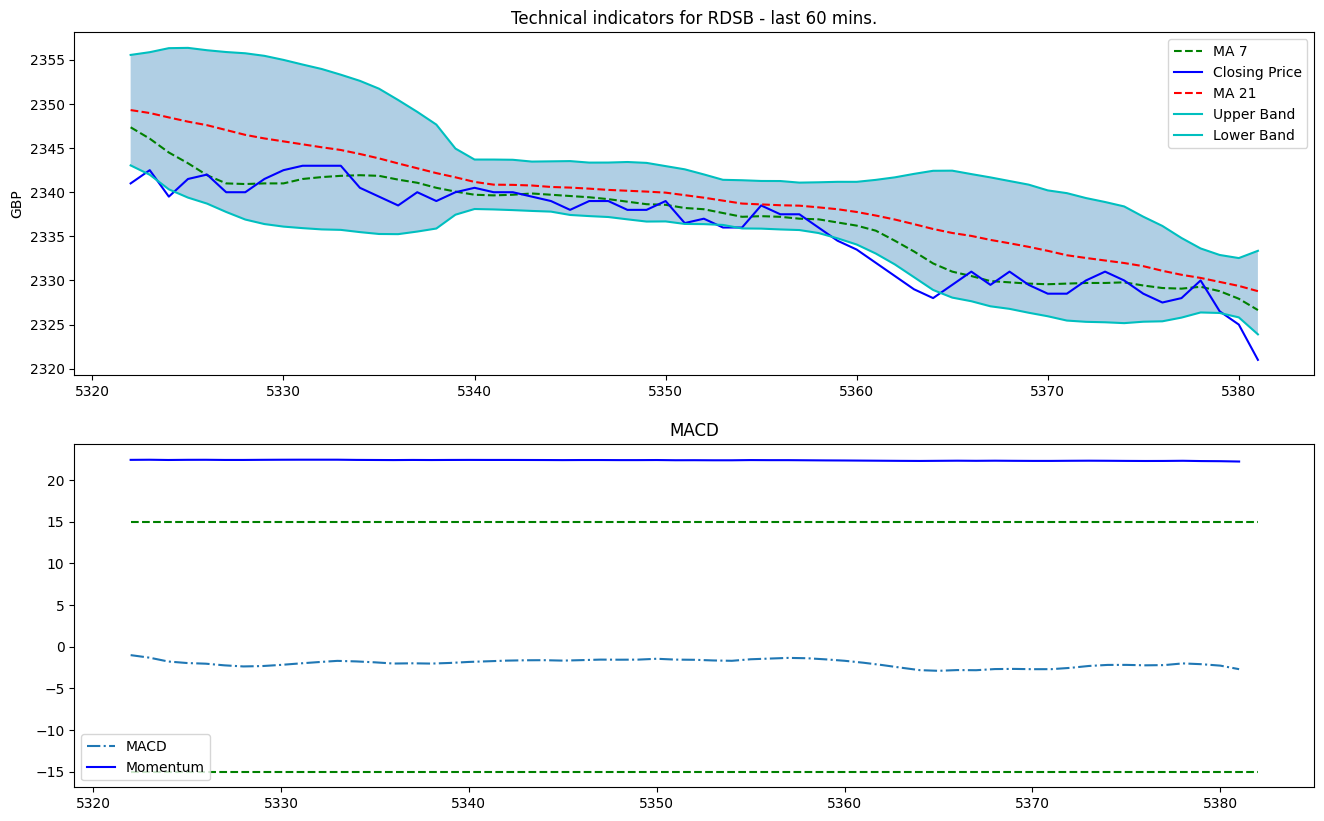

In [ ]:
plot_technical_indicators(dataset_TI_df, 60)

**3. Time Series Analysis using Fourier Transform**

In [18]:
data_FT = dataset_ex_df[['Dates', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

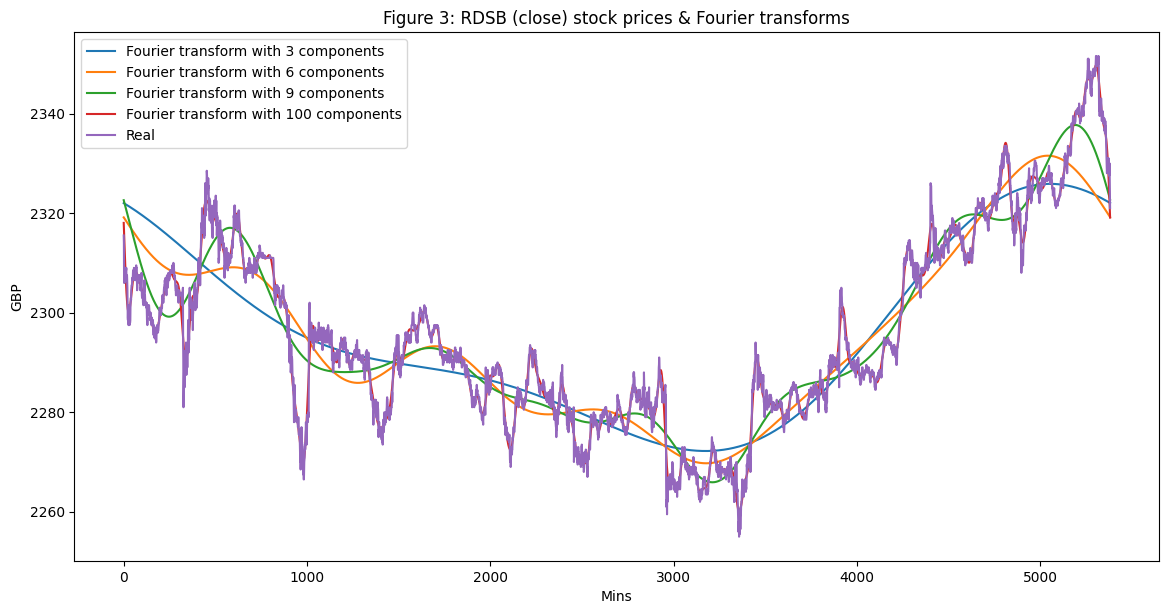

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Mins')
plt.ylabel('GBP')
plt.title('Figure 3: RDSB (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [19]:
def get_fourier(dataset):
    data_FT = dataset[['Dates', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    dataset['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return dataset

In [20]:
dataset_TI_df = get_fourier(dataset_ex_df)
dataset_TI_df.head(3)

Dates    Open   Close  ...          ema  momentum  Fourier
0 2018-02-14 08:00:00  4835.5  4832.5  ...  4832.500000    47.325   4832.5
1 2018-02-14 08:01:00  4832.5  4832.5  ...  4832.500000    47.325   4832.5
2 2018-02-14 08:02:00  4834.5  4830.0  ...  4830.769231    47.300   4830.0

[3 rows x 18 columns]

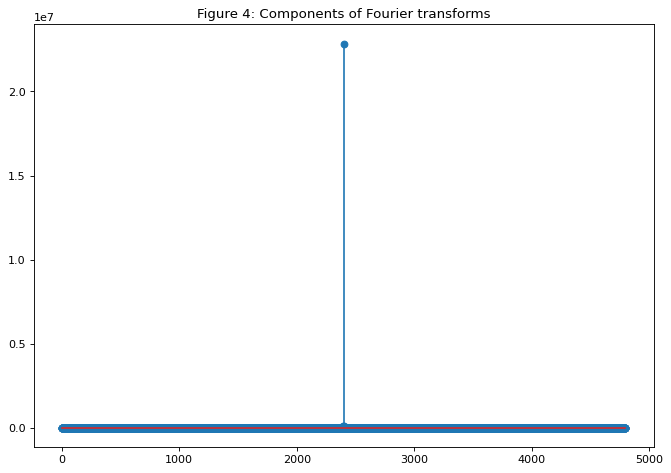

In [21]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

**4. ARIMA model as a feature**

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4795
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -12194.338
Method:                       css-mle   S.D. of innovations              3.078
Date:                Mon, 10 Aug 2020   AIC                          24402.675
Time:                        20:14:15   BIC                          24448.003
Sample:                             1   HQIC                         24418.595
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0067      0.037     -0.184      0.854      -0.078       0.065
ar.L1.D.Close    -0.0583      0.014     -4.043      0.000      -0.087      -0.030
ar.L2.D.Close    -0.0576      0.014     

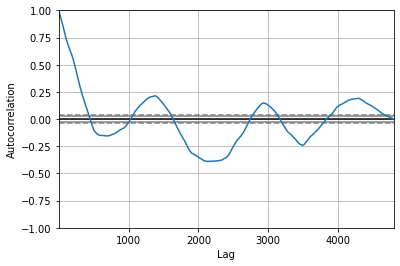

<Figure size 800x560 with 0 Axes>

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

In [24]:
from pandas import datetime
from pandas import DataFrame


X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

dataset_TI_df['ARIMA'] = pd.DataFrame(predictions)

In [25]:
from math import sqrt
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mean_squared_error(test, predictions))
accuracy = r2_score(test, predictions)
print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)
print('Test accuracy: %.3f' % accuracy)

Test MSE: 4.146
Test MAE: 1.387
Test RMSE: 2.036
Test accuracy: 0.996


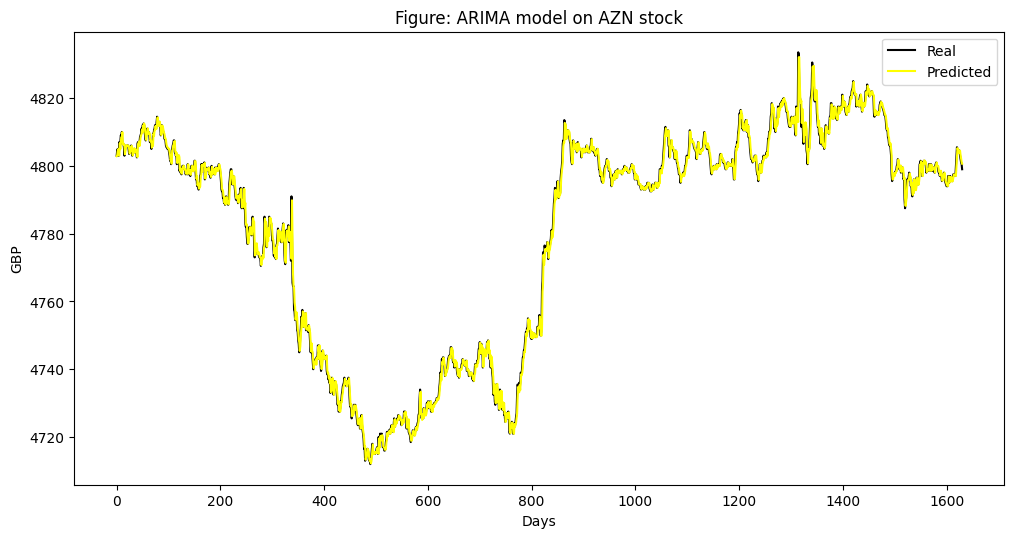

In [28]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('Days')
plt.ylabel('GBP')
plt.title('Figure: ARIMA model on AZN stock')
plt.legend()
plt.show()

In [29]:
dataset_ex_df.head(3)

Dates    Open   Close  ...  momentum  Fourier        ARIMA
0 2018-02-14 08:00:00  4835.5  4832.5  ...    47.325   4832.5  4802.847700
1 2018-02-14 08:01:00  4832.5  4832.5  ...    47.325   4832.5  4803.057467
2 2018-02-14 08:02:00  4834.5  4830.0  ...    47.300   4830.0  4804.386656

[3 rows x 19 columns]

#Add correlated assets as features

In [30]:
dataset_ex_df['WTB'] = dataset_CA['WTB']
print(dataset_ex_df.head(2))
print('Shape of datset after adding all features')
print(dataset_ex_df.shape)

                Dates    Open   Close  ...  Fourier        ARIMA   WTB
0 2018-02-14 08:00:00  4835.5  4832.5  ...   4832.5  4802.847700  3815
1 2018-02-14 08:01:00  4832.5  4832.5  ...   4832.5  4803.057467  3818

[2 rows x 20 columns]
Shape of datset after adding all features
(4796, 20)


In [31]:
dataset_ex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4796 entries, 0 to 4795
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Dates       4796 non-null   datetime64[ns]
 1   Open        4796 non-null   float64       
 2   Close       4796 non-null   float64       
 3   High        4796 non-null   float64       
 4   Low         4796 non-null   float64       
 5   Value       4796 non-null   float64       
 6   Volume      4796 non-null   int64         
 7   ma7         4790 non-null   float64       
 8   ma21        4776 non-null   float64       
 9   26ema       4796 non-null   float64       
 10  12ema       4796 non-null   float64       
 11  MACD        4796 non-null   float64       
 12  20sd        4777 non-null   float64       
 13  upper_band  4777 non-null   float64       
 14  lower_band  4777 non-null   float64       
 15  ema         4796 non-null   float64       
 16  momentum    4796 non-nul

In [32]:
print('Total dataset has {} samples, and {} features.'.format(dataset_ex_df.shape[0], \
                                                              dataset_ex_df.shape[1]))

Total dataset has 4796 samples, and 20 features.


#Feature Selection

In [ ]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:,1:19]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

*Importance of Technical Indicators*

In [ ]:
# Get training and test data
(X_train_TI, y_train_TI), (X_test_TI, y_test_TI) = get_feature_importance_data(dataset_TI_df)

In [ ]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [ ]:
xgbModel = regressor.fit(X_train_TI,y_train_TI, \
                         eval_set = [(X_train_TI, y_train_TI), (X_test_TI, y_test_TI)], \
                         verbose=False)

In [ ]:
eval_result = regressor.evals_result()

In [ ]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

In [ ]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_TI.columns)
plt.title('Figure: Feature importance of the Technical Indicators.')
plt.show()

*Importance of all features*

In [33]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:,1:19]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train1 = X.iloc[:train_samples]
    X_test1 = X.iloc[train_samples:]

    y_train1 = y.iloc[:train_samples]
    y_test1 = y.iloc[train_samples:]
    
    return (X_train1, y_train1), (X_test1, y_test1)

In [34]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_ex_df)

In [35]:
regressor1 = xgb.XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [36]:
xgbModel = regressor1.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[20:24:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [37]:
eval_result1 = regressor1.evals_result()

In [38]:
training_rounds1 = range(len(eval_result1['validation_0']['rmse']))

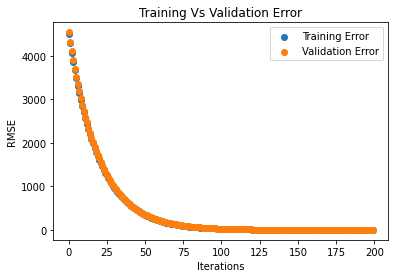

In [39]:
plt.scatter(x=training_rounds1,y=eval_result1['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds1,y=eval_result1['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

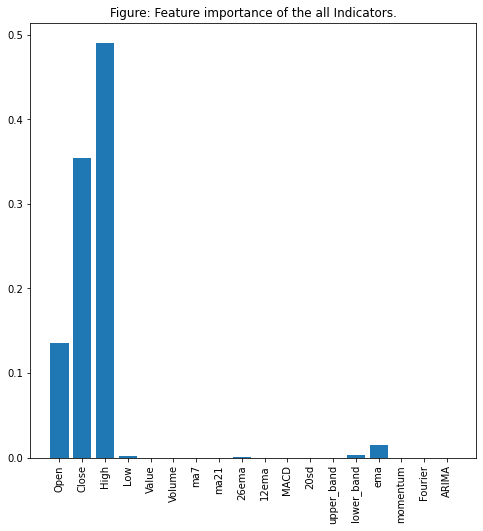

In [40]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure: Feature importance of the all Indicators.')
plt.show()

#Pre-Processing

*Scenario 1*

In [42]:
#Five most significant features
dataset_S1 = dataset_ex_df[['Dates','Open','Close','High','Low','26ema','lower_band','ema']]
dataset_S1.fillna(0, inplace=True)
print(dataset_S1.head(3))
                               

                Dates    Open   Close  ...        26ema  lower_band          ema
0 2018-02-14 08:00:00  4835.5  4832.5  ...  4832.500000         0.0  4832.500000
1 2018-02-14 08:01:00  4832.5  4832.5  ...  4832.500000         0.0  4832.500000
2 2018-02-14 08:02:00  4834.5  4830.0  ...  4831.601774         0.0  4830.769231

[3 rows x 8 columns]


#Optimal-Modeling Filter

**1.Optimal ML model for Predicting Stock Price Movement Direction**


1.   Trigger1 -> TA1-> Request1 -> Layer1 -> Train LSTM, XGBoost 
2.   Select ML model with optimal performance metrics for lowest execution time
3.   Test optimal ML model



*Scenario-1*

In [44]:
dataset = dataset_S1[['Open','Close','High','Low','26ema','ema']]
dataset.head(3)

Open   Close    High     Low        26ema          ema
0  4835.5  4832.5  4838.0  4832.5  4832.500000  4832.500000
1  4832.5  4832.5  4832.5  4832.5  4832.500000  4832.500000
2  4834.5  4830.0  4838.0  4830.0  4831.601774  4830.769231

In [45]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [46]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [88]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])
dataset.head(3)

Open   Close    High     Low        26ema          ema
0  4835.5  4832.5  4838.0  4832.5  4832.500000  4832.500000
1  4832.5  4832.5  4832.5  4832.5  4832.500000  4832.500000
2  4834.5  4830.0  4838.0  4830.0  4831.601774  4830.769231

In [69]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [89]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
ORDSB_avg = dataset.mean(axis = 1)
RDSB_avg = dataset[['High', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

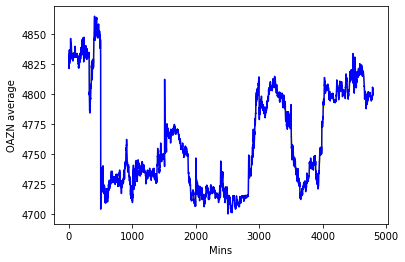

In [71]:
# PLOTTING All INDICATORS IN PLOT
plt.plot(ORDSB_avg, 'yellow', label = 'OAZN avg')
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Mins')
plt.ylabel('OAZN average')
plt.show()

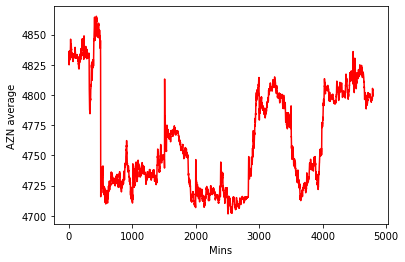

In [53]:
plt.plot(RDSB_avg, 'red', label = 'AZN avg')
plt.xlabel('Mins')
plt.ylabel('AZN average')
plt.show()

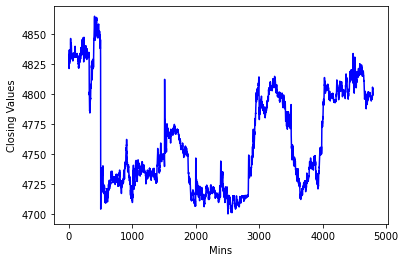

In [54]:
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Mins')
plt.ylabel('Closing Values')
plt.show()

In [72]:
# PREPARATION OF TIME SERIES DATASE
ORDSB_avg = np.reshape(ORDSB_avg.values, (len(ORDSB_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
ORDSB_avg = scaler.fit_transform(ORDSB_avg)

In [ ]:
ORDSB_avg.shape

In [73]:
# TRAIN-TEST SPLIT
train_ORDSB = int(len(ORDSB_avg) * 0.75)
test_ORDSB = len(ORDSB_avg) - train_ORDSB
train_ORDSB, test_ORDSB = ORDSB_avg[0:train_ORDSB,:], ORDSB_avg[train_ORDSB:len(ORDSB_avg),:]

In [58]:
ORDSB_avg.shape

(4796, 1)

In [74]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_ORDSB, 1)
testX, testY = new_dataset(test_ORDSB, 1)

In [75]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [76]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [77]:
# MODEL COMPILING AND TRAINING
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae']) 
print ('compilation time : ', time.time() - start)
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

compilation time :  0.015246391296386719
Epoch 1/50
3595/3595 - 6s - loss: 0.0045 - mae: 0.0267
Epoch 2/50
3595/3595 - 7s - loss: 2.8632e-04 - mae: 0.0089
Epoch 3/50
3595/3595 - 7s - loss: 3.1647e-04 - mae: 0.0093
Epoch 4/50
3595/3595 - 7s - loss: 3.0379e-04 - mae: 0.0092
Epoch 5/50
3595/3595 - 7s - loss: 3.1371e-04 - mae: 0.0089
Epoch 6/50
3595/3595 - 7s - loss: 3.0043e-04 - mae: 0.0091
Epoch 7/50
3595/3595 - 7s - loss: 2.9000e-04 - mae: 0.0090
Epoch 8/50
3595/3595 - 7s - loss: 3.1615e-04 - mae: 0.0095
Epoch 9/50
3595/3595 - 7s - loss: 2.8265e-04 - mae: 0.0087
Epoch 10/50
3595/3595 - 7s - loss: 3.1863e-04 - mae: 0.0092
Epoch 11/50
3595/3595 - 6s - loss: 2.9362e-04 - mae: 0.0088
Epoch 12/50
3595/3595 - 7s - loss: 2.9475e-04 - mae: 0.0090
Epoch 13/50
3595/3595 - 7s - loss: 3.0172e-04 - mae: 0.0089
Epoch 14/50
3595/3595 - 7s - loss: 2.9627e-04 - mae: 0.0091
Epoch 15/50
3595/3595 - 6s - loss: 2.8719e-04 - mae: 0.0089
Epoch 16/50
3595/3595 - 6s - loss: 3.0139e-04 - mae: 0.0088
Epoch 17/50


In [78]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

75/75 [==============================] - 0s 1ms/step - loss: 7.2728e-05 - mae: 0.0063
Mean Absolute Error for Y: [7.272759103216231e-05, 0.006342098116874695]


In [79]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [80]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [81]:
# TRAINING mse,rmse,mae, r2_score
trainScore1 = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train mse : %.2f' % (trainScore1))
trainScore2 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train rmse : %.2f' % (trainScore2))
trainScore3 = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train mae : %.2f' % (trainScore3))
trainScore4 = r2_score(trainY[0], trainPredict[:,0])
print('Train r2_score : %.2f' % (trainScore4))


Train mse : 5.71
Train rmse : 2.39
Train mae : 1.11
Train r2_score : 1.00


In [82]:
# TEST RMSE
testScore1 = mean_squared_error(testY[0], testPredict[:,0])
print('Test MSE: %.2f' % (testScore1))
testScore2 = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore2))
testScore3 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test mae: %.2f' % (testScore3))
testScore4 = r2_score(testY[0], testPredict[:,0])
print('Test r2_score: %.2f' % (testScore4))

Test MSE: 1.87
Test RMSE: 1.37
Test mae: 1.02
Test r2_score: 1.00


In [83]:
# CREATING SIMILAR DATASET TO PLOT REAL PREDICTIONS
trainPredictPlot = np.empty_like(ORDSB_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [ ]:
trainPredictPlot.shape

In [84]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(ORDSB_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(ORDSB_avg)-1, :] = testPredict

In [86]:
testY.shape

(1, 1197)

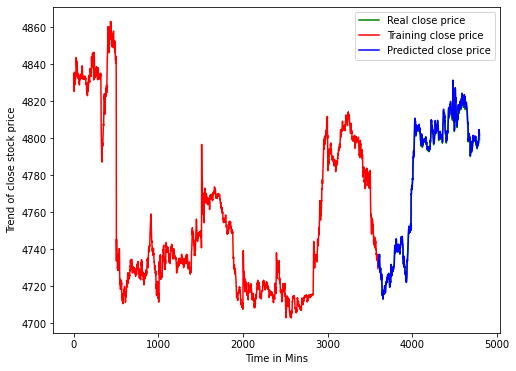

In [90]:
plt.figure(figsize=(8,6))
real_close = ORDSB_avg[-1197: ]
real_close
plt.plot(real_close, 'g', label = 'Real close price')
plt.plot(trainPredictPlot, 'r', label = 'Training close price')
plt.plot(testPredictPlot, 'b', label = 'Predicted close price')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Mins')
plt.ylabel('Trend of close stock price')
plt.show()

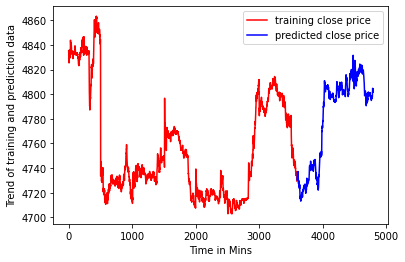

In [91]:
# PLOT OF MAIN ORDSB VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(trainPredictPlot, 'r', label = 'training close price')
plt.plot(testPredictPlot, 'b', label = 'predicted close price')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Mins')
plt.ylabel('Trend of training and prediction data')
plt.show()

In [92]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Min Value:", np.asscalar(last_val))
print("Next Min Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

Last Min Value: 4801.5771484375
Next Min Value: 4816.2099609375


#XGBoost

In [94]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])
dataset.head(3)

Open   Close    High     Low        26ema          ema
0  4835.5  4832.5  4838.0  4832.5  4832.500000  4832.500000
1  4832.5  4832.5  4832.5  4832.5  4832.500000  4832.500000
2  4834.5  4830.0  4838.0  4830.0  4831.601774  4830.769231

In [95]:
def get_mean(df, col):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df.mean(axis=1) # len(mean_list) = len(df)
     
    # Add one timestep to the predictions
    #mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    #std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    #df_out[col + '_std'] = std_list
    
    return df_out

In [96]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [98]:
cols_list = [
"Open",
"Close",
"Low",
"26ema",
"High",
"ema"
]

for col in cols_list:
    ORDSB_avg = get_mean(dataset, col)
ORDSB_avg.head(3)

Open   Close    High     Low        26ema          ema     ema_mean
0  4835.5  4832.5  4838.0  4832.5  4832.500000  4832.500000  4833.916667
1  4832.5  4832.5  4832.5  4832.5  4832.500000  4832.500000  4832.500000
2  4834.5  4830.0  4838.0  4830.0  4831.601774  4830.769231  4832.478501

In [99]:
df1_RDSB = ORDSB_avg
df1_RDSB.head(2)

Open   Close    High     Low   26ema     ema     ema_mean
0  4835.5  4832.5  4838.0  4832.5  4832.5  4832.5  4833.916667
1  4832.5  4832.5  4832.5  4832.5  4832.5  4832.5  4832.500000

In [100]:
import plotly.graph_objects as go
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df1_RDSB.shape[0] * (1-test_size))
valid_split_idx = int(df1_RDSB.shape[0] * (1-(valid_size+test_size)))

train_df1_RDSB  = df1_RDSB.loc[:valid_split_idx].copy()
valid_df1_RDSB  = df1_RDSB.loc[valid_split_idx+1:test_split_idx].copy()
test_df1_RDSB   = df1_RDSB.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df1_RDSB.index, y=train_df1_RDSB.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df1_RDSB.index, y=valid_df1_RDSB.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df1_RDSB.index,  y=test_df1_RDSB.Close,  name='Test'))
fig.show()

In [102]:
drop_cols = ['Open','High','Low','26ema']

train_df1_RDSB = train_df1_RDSB.drop(drop_cols, 1)
valid_df1_RDSB = valid_df1_RDSB.drop(drop_cols, 1)
test_df1_RDSB  = test_df1_RDSB.drop(drop_cols, 1)

In [103]:
# Split into features and labels
y_train = train_df1_RDSB['Close'].copy()
X_train = train_df1_RDSB.drop(['Close'], 1)

y_valid = valid_df1_RDSB['Close'].copy()
X_valid = valid_df1_RDSB.drop(['Close'], 1)

y_test  = test_df1_RDSB['Close'].copy()
X_test  = test_df1_RDSB.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3358 entries, 0 to 3357
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ema       3358 non-null   float64
 1   ema_mean  3358 non-null   float64
dtypes: float64(2)
memory usage: 52.6 KB


In [104]:
from sklearn.model_selection import train_test_split, GridSearchCV
#### Fine-tune XGBoostRegressor
# %%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}
start = time.time() ####
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')
print ('compilation time : ', time.time() - start) 

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 400, 'random_state': 42}
Best validation score = 0.9570086649874343
compilation time :  272.0436964035034


In [105]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [106]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [4804.  4805.5 4806.  4808.  4805. ]
y_pred = [4803.6367 4805.4795 4805.838  4807.2207 4805.838 ]


In [107]:
print(f'mse = {mean_squared_error(y_test, y_pred)}')
print(f'rmse = {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'mae = {mean_absolute_error(y_test, y_pred)}')
print(f'r2_score = {r2_score(y_test, y_pred)}')

mse = 0.9398043298257077
rmse = 0.969435057043899
mae = 0.7374907640820584
r2_score = 0.9878169661836816


In [109]:
real_close_xgb = df1_RDSB.Close
predicted_prices = df1_RDSB.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred
y=predicted_prices.Close

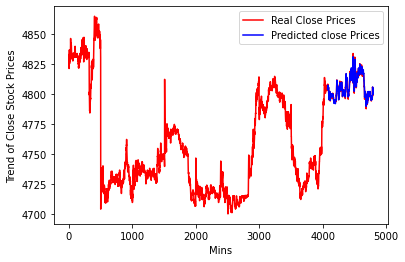

In [110]:
import matplotlib.pyplot as plt
#predicted_stateful = y_pred
plt.plot(real_close_xgb, color = 'red',label = 'Real Close Prices')
#plt.plot(y_test, color = 'red',label = 'Training Close Prices')
plt.plot(y, color = 'blue', label  = 'Predicted close Prices')
plt.xlabel('Mins')
plt.ylabel('Trend of Close Stock Prices')
plt.legend(loc='best')
plt.show()

In [113]:

from plotly.subplots import make_subplots
predicted_prices = df1_RDSB.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df1_RDSB.index, y=df1_RDSB.Close,
                         name='Real Close Price',
                         marker_color='Red'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.Close,
                         name='Predicted Close Price',
                         marker_color='Blue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_test,
                         name='Truth',
                         marker_color='Red',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_pred,
                         name='Prediction',
                         marker_color='Blue',
                         showlegend=False), row=2, col=1)
fig.show()

#Linear Regression

Reference: 
https://github.com/AdamLouly/Stockprediction/blob/master/stockpredi.ipynb

In [115]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])
dataset.head(3)

Open   Close    High     Low        26ema          ema
0  4835.5  4832.5  4838.0  4832.5  4832.500000  4832.500000
1  4832.5  4832.5  4832.5  4832.5  4832.500000  4832.500000
2  4834.5  4830.0  4838.0  4830.0  4831.601774  4830.769231

In [116]:
def get_mean(df, col):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df.mean(axis=1) # len(mean_list) = len(df)
     
    # Add one timestep to the predictions
    #mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    #std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    #df_out[col + '_std'] = std_list
    
    return df_out

In [ ]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [118]:
cols_list = [
"Open",
"Low",
"Close",
"26ema",
"High",
"ema"
]

for col in cols_list:
    ORDSB_avg = get_mean(dataset, col)
ORDSB_avg.head(3)

Open   Close    High     Low        26ema          ema     ema_mean
0  4835.5  4832.5  4838.0  4832.5  4832.500000  4832.500000  4833.916667
1  4832.5  4832.5  4832.5  4832.5  4832.500000  4832.500000  4832.500000
2  4834.5  4830.0  4838.0  4830.0  4831.601774  4830.769231  4832.478501

In [122]:
df1_RDSB = ORDSB_avg.drop(['Open','Low','High','26ema'],axis=1)
df1_RDSB.head(3)

Close          ema     ema_mean
0  4832.5  4832.500000  4833.916667
1  4832.5  4832.500000  4832.500000
2  4830.0  4830.769231  4832.478501

In [124]:
#split into train and validation
train = df1_RDSB[:1197]
valid = df1_RDSB[1197:]

x_train = train.drop('ema_mean', axis=1)
y_train = train['ema_mean']
x_valid = valid.drop('ema_mean', axis=1)
y_valid = valid['ema_mean']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [125]:
#make predictions and find the rmse
preds = model.predict(x_valid)

In [126]:
from sklearn import metrics
# Calculate and print values of MAE, MSE, RMSE
print('mae:', metrics.mean_absolute_error(y_valid, preds))  
print('mse:', metrics.mean_squared_error(y_valid, preds))  
print('rmse:', np.sqrt(metrics.mean_squared_error(y_valid, preds)))
print('r2_score:', metrics.r2_score(y_valid,preds)) 

mae: 0.554768744820413
mse: 0.6002683545861422
rmse: 0.7747698720175832
r2_score: 0.9995535576701965


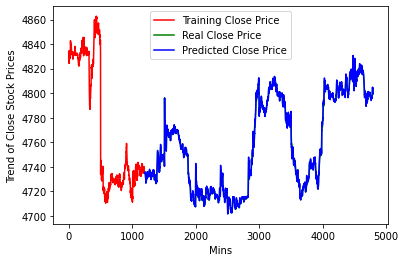

In [127]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = df1_RDSB[1197:].index
train.index = df1_RDSB[:1197].index

plt.plot(train['ema_mean'], color ='r', Label= 'Training Close Price')
plt.plot(valid[['ema_mean']],color = 'g', label = 'Real Close Price' )
plt.plot(valid[['Predictions']],color = 'b', label = 'Predicted Close Price' )
plt.xlabel('Mins')
plt.ylabel('Trend of Close Stock Prices')
plt.legend(loc='best')
plt.show()

#LR2

reference: https://github.com/mediasittich/Predicting-Stock-Prices-with-Linear-Regression/blob/master/Predicting%20Stock%20Prices%20with%20Linear%20Regression.ipynb

In [151]:
ORDSB_avg.columns

Index(['Open', 'Close', 'High', 'Low', '26ema', 'ema', 'ema_mean'], dtype='object')

In [153]:
df1_RDSB = ORDSB_avg.drop(['Open','High','Low','ema','26ema','Close',],axis=1)
# IMPORTING DATASET 
df1_RDSB = df1_RDSB.reindex(index = df1_RDSB.index[::-1])
df1_RDSB.head()

ema_mean
0  4833.916667
1  4832.500000
2  4832.478501
3  4830.983998
4  4829.844615

In [154]:
# Import package for linear model
from sklearn.linear_model import LinearRegression

In [155]:
# Split data into train and test set: 80% / 20%
train, test = train_test_split(df1_RDSB, test_size=0.20)

In [156]:
# Reshape index column to 2D array for .fit() method
X_train = np.array(train.index).reshape(-1, 1)
y_train = train['ema_mean']

In [157]:
# Create LinearRegression Object
model = LinearRegression()
start = time.time() #####
# Fit linear model using the train data set
pred_LR = model.fit(X_train, y_train)
print ('compilation time : ', time.time() - start) 

compilation time :  0.002553224563598633


In [158]:
#model evaluation
# The coefficient
print('Slope: ', np.asscalar(np.squeeze(model.coef_)))
# The Intercept
print('Intercept: ', model.intercept_)

Slope:  0.003386595354046373
Intercept:  4753.717372708139


Interpreting the coefficients:

The slope coefficient tells us that with a 1 unit increase in date the closing price increases by 0.0276 $
The intercept coefficient is the price at wich the closing price measurement started, the stock price value at date zero

In [159]:
predicted_prices = df1_RDSB.loc[test_split_idx+1:].copy()
predicted_prices['ema_mean'] = pred_LR
y1=predicted_prices.ema_mean

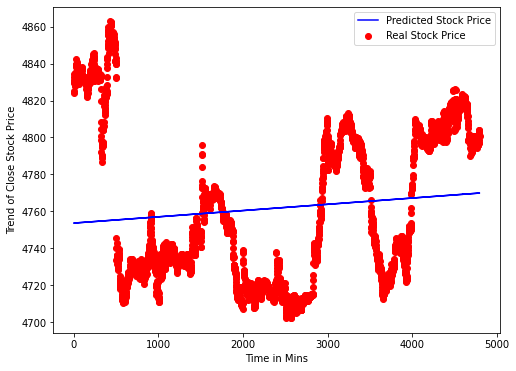

In [160]:
# Train set graph
plt.figure(1, figsize=(8,6))
plt.scatter(X_train, y_train, color='r', label='Real Stock Price')
plt.plot(X_train, model.predict(X_train), color='b', label='Predicted Stock Price')
plt.xlabel('Time in Mins')
plt.ylabel('Trend of Close Stock Price')
plt.legend()
plt.show()

In [161]:
# Create test arrays
X_test = np.array(test.index).reshape(-1, 1)
y_test = test['ema_mean']

In [162]:
# Generate array with predicted values
y_pred = model.predict(X_test)

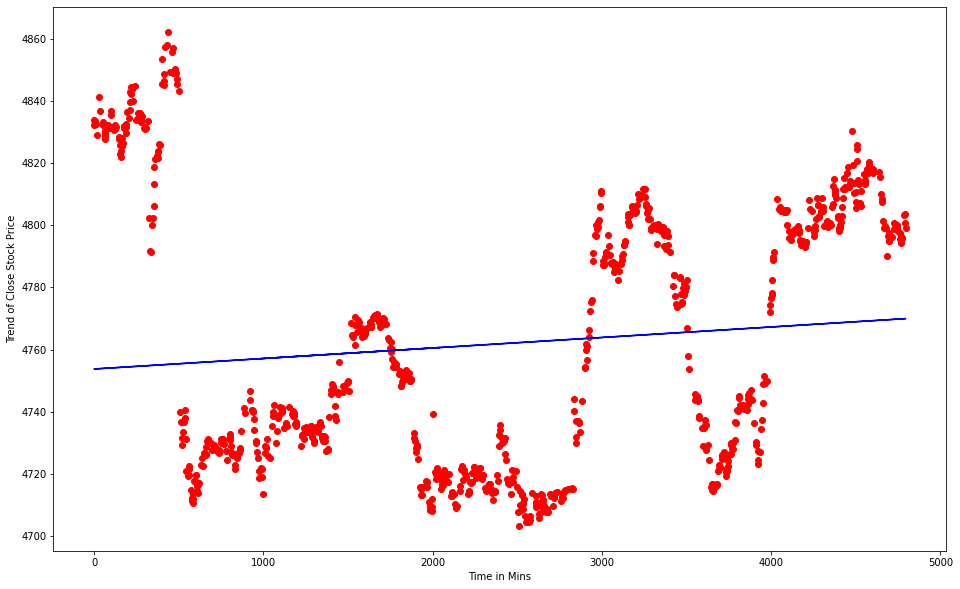

In [163]:
#model performance over the whole test data set.
# Plot fitted line, y test
plt.figure(1, figsize=(16,10))
plt.plot(X_test, model.predict(X_test), color='b', label='Predicted Stock Price')
plt.scatter(X_test, y_test, color='r', label='Real Stock Price')

plt.xlabel('Time in Mins')
plt.ylabel('Trend of Close Stock Price')

plt.show()

In [164]:
from sklearn import metrics
# Calculate and print values of MAE, MSE, RMSE
print('mae:', metrics.mean_absolute_error(y_test, y_pred))  
print('mse:', metrics.mean_squared_error(y_test, y_pred))  
print('rmse:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2_score:', metrics.r2_score(y_test, y_pred)) 

mae: 36.58988128728475
mse: 1737.1098682153781
rmse: 41.67865002870628
r2_score: 0.011605352697346527


#KNN

reference: 
https://github.com/AdamLouly/Stockprediction/blob/master/stockpredi.ipynb

In [165]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [146]:
ORDSB_avg.columns

Index(['Open', 'Close', 'High', 'Low', '26ema', 'ema', 'ema_mean'], dtype='object')

In [167]:
df1_RDSB = ORDSB_avg.drop(['Open','High','Low','26ema'],axis=1)
df1_RDSB = df1_RDSB.reindex(index = df1_RDSB.index[::-1])
df1_RDSB.head()

Close          ema     ema_mean
0  4832.5  4832.500000  4833.916667
1  4832.5  4832.500000  4832.500000
2  4830.0  4830.769231  4832.478501
3  4830.0  4830.250000  4830.983998
4  4829.0  4829.413223  4829.844615

In [168]:
#split into train and validation
train = df1_RDSB[:1197]
valid = df1_RDSB[1197:]

x_train = train.drop('ema_mean', axis=1)
y_train = train['ema_mean']
x_valid = valid.drop('ema_mean', axis=1)
y_valid = valid['ema_mean']

In [169]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
start = time.time() #####
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
print ('compilation time : ', time.time() - start) 
preds_KNN = model.predict(x_valid)

compilation time :  0.2072155475616455


In [170]:
from sklearn import metrics
# Calculate and print values of MAE, MSE, RMSE
print('mae:', metrics.mean_absolute_error(y_valid, preds_KNN))  
print('mse:', metrics.mean_squared_error(y_valid, preds_KNN))  
print('rmse:', np.sqrt(metrics.mean_squared_error(y_valid, preds_KNN)))
print('r2_score:', metrics.r2_score(y_valid, preds_KNN)) 

mae: 18.792282449074765
mse: 409.36254058764507
rmse: 20.232709669929164
r2_score: 0.6955415607736699


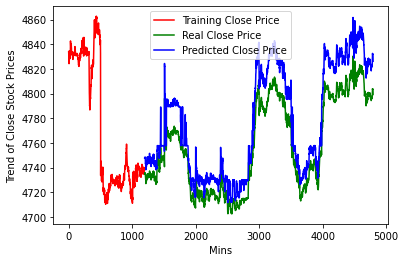

In [171]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds_KNN

valid.index = df1_RDSB[1197:].index
train.index = df1_RDSB[:1197].index

plt.plot(train['ema_mean'], color ='r', Label= 'Training Close Price')
plt.plot(valid[['ema_mean']],color = 'g', label = 'Real Close Price' )
plt.plot(valid[['Predictions']],color = 'b', label = 'Predicted Close Price' )
plt.xlabel('Mins')
plt.ylabel('Trend of Close Stock Prices')
plt.legend(loc='best')
plt.show()

#SVR

reference
https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650

http://www.saedsayad.com/support_vector_machine_reg.htm?source=post_page-----8eb3acf6d0ff----------------------


https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72

https://www.cs.princeton.edu/sites/default/files/uploads/saahil_madge.pdf

https://www.researchgate.net/publication/255995594_Predicting_Stock_Market_Price_Using_Support_Vector_Regression#:~:text=In%20this%20study%2C%20support%20vector,to%20predict%20stock%20market%20trend.&text=It%20can%20produce%20good%20prediction,parameters%20can%20be%20determined%20properly.

In [176]:
from sklearn.svm import SVR
start = time.time() #####
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(x_train,y_train )
print ('compilation time : ', time.time() - start) 

compilation time :  0.15758967399597168


In [177]:
preds_SVR = model.predict(x_valid)

# Calculate and print values of MAE, MSE, RMSE
print('mae:', metrics.mean_absolute_error(y_valid, preds_SVR))  
print('mse:', metrics.mean_squared_error(y_valid, preds_SVR))  
print('rmse:', np.sqrt(metrics.mean_squared_error(y_valid, preds_SVR)))
print('r2_score:', metrics.r2_score(y_valid, preds_SVR)) 

mae: 18.792282449074765
mse: 409.36254058764507
rmse: 20.232709669929164
r2_score: 0.6955415607736699


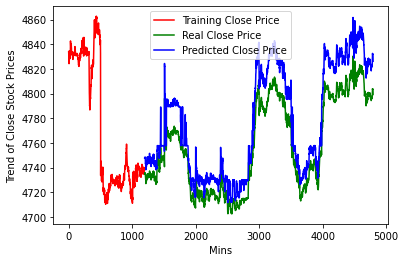

In [175]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds_SVR

valid.index = df1_RDSB[1197:].index
train.index = df1_RDSB[:1197].index

plt.plot(train['ema_mean'], color ='r', Label= 'Training Close Price')
plt.plot(valid[['ema_mean']],color = 'g', label = 'Real Close Price' )
plt.plot(valid[['Predictions']],color = 'b', label = 'Predicted Close Price' )
plt.xlabel('Mins')
plt.ylabel('Trend of Close Stock Prices')
plt.legend(loc='best')
plt.show()